## 序列接口
序列以**外在**顺序维护一组项目，其中每个被存储的项在序列中都有**排名**，包括首项和末项。

序列是栈和队列的推广，它们支持序列操作的子集。

注意：
- 通过说**外在的**，我们想表达的意思是：首项之所以是第一个，不是因为这个项是什么，而是因为一些外在的原因把它放在那儿。

序列有哪些操作？

- 容器操作

  `build(X)`：给定可迭代对象X，用X中的项来构建序列
  
  `len()`：返回存储的项的个数

- 静态操作

  `iter_seq()`：按照序列顺序一个接一个地返回存储的项

  `get_at(i)`：返回第i个项
  
  `set_at(i, x)`：用x来替换第i个项

- 动态操作

  `insert_at(i, x)`：把x作为第i个项添加到序列中
  
  `delete_at(i)`：移除并返回第i个项
  
  `insert_first(x)`：将x作为第一个项添加到列表中
  
  `deleter_first()`：移除并返回第一个项
  
  `insert_last(x)`：将x作为最后一项添加到列表中
  
  `delete_last()`：移除并返回最后一个项
  
注意：`insert_/delete_`操作会修改在被修改项之后的所有项的排名。

## 集合接口
作为对比，集合基于一种**内在性质**来维护一组项目。这里所说的内在性质通常跟项是什么有关，基于一个唯一键key，比如x.key，每个项x都关联有一个。

集合是字典以及其他内在属性查询数据库的推广。

集合都有哪些操作？
- 容器类操作

  `build(X)`：给定一个可迭代对象X，用X的项来构建集合
  
  `len()`：返回存储的项的个数
- 静态操作

  `find(k)`：返回键值为k的项
- 动态操作

  `insert(x)`：将x添加到集合中。如果已存在x.key对应的项，那么就用x替换它。
  
  `delete(k)`：移除并返回键值为k的存储的项
- 序操作

  `iter_ord()`：按照键的顺序一个接一个地返回存储的项
  
  `find_min()`：返回具有最小键值的存储的项

  `find_max()`：返回具有最大键值的存储的项
  
  `find_next(k)`：返回比键值k大的最小键值的存储的项
  
  `find_prev(k)`：返回比键值k小的最大键值的存储的项
  
注意：如果不存在所查询的项，那么`find`操作就返回None。

## 序列实现
这里，我们将讨论3种实现了序列接口的数据结构。

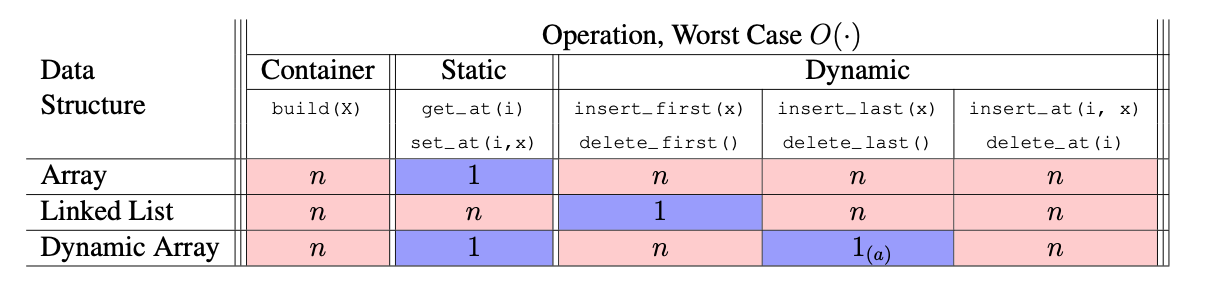

## 数组序列
计算机内存是一种有限的资源。在现代计算机上，许多进程可能共享同一个主内存存储，所以操作系统将给每个活跃进程分配一个固定的内存地址块。所分配的内存量取决于进程的需要，以及可用的空闲内存。比如，当一个计算机程序请求存储一个变量时，程序必须告诉操作系统存储它需要多大的内存。为了完成这个请求，操作系统将在进程的所分配内存地址空间中找到可用的内存，并分配它直到不再使用。虽然内存管理和分配是一个被包括Python在内的许多高级语言抽象出来的细节，但要知道：无论何时你请求Python去存储一些内容，Python都会在背后向操作系统发出一个请求，即用固定量的内存来存储它。

现在，假设一个计算机程序想存储两个数组，每个都存储10个大小为64位的字。程序会为两个内存块(每个大小为640位)发出单独的请求。比如，通过把进程分配的地址空间里的前10个字保留给第一个数组A，接下来的10个字保留给第二个数组B，操作系统来满足这两个请求。

现在，假设随着计算机的执行，需要在数组A中存储第11个字w。似乎在A附近没有空间来存储这个新的字w：这个进程分配的地址空间开始于A的左侧，数组B被存储在它的右侧。

然后，我们该如何把w添加到A中？

一种方案是将数组B向右移动，给w腾出空间。但是紧邻B已经保留了许多数据，这个你可能也不得不移动。

更好的做法是请求具有11个字的新内存，将数组A拷贝到新内存分配的开始，将w存储到末尾。清空该进程地址空间里的前10个字用于将来的内存请求。


一个固定大小的数组是一个数据结构，它是我们计算模型的底层基础，你可以把你的电脑内存看做是一个很大的固定长度数组，操作系统从那儿分配内存。

使用数组来实现一个序列，其中索引i对应序列中的第i项，它允许`get_at`以及`set_at`的运行时间为O(1)，因为我们的随机访问机器。

但是，当从序列中删除或者向序列中插入时，我们需要移动项，并重新设置数组的大小，意味着这些操作在最坏情形下可能花费线性时间。

In [1]:
class Array_seq:
    def __init__(self):
        self.A = []
        self.size = 0
        
    def __len__(self):
        return self.size
    
    def __iter__(self):
        yield from self.A
        
    def build(self, X):
        self.A = [a for a in X]
        self.size = len(self.A)
        
    def get_at(self, i):
        return self.A[i]
    
    def set_at(self, i, x):
        self.A[i] = x
        
    def insert_at(self, i, x):
        n = len(self.A)
        A = [None]*(n+1)
        self._copy_forward(0,i,A,0)
        A[i] = x
        self._copy_forward(i, n-i, A, i+1)
        self.build(A)
        
    def _copy_forward(self, i, n, A, j):
        for k in rang(n):
            A[j+k] = self.A[i+k]
            
    def delete_at(self, i):
        n = len(self)
        A = [None]*(n-1)
        self._copy_forward(0,i,A,0)
        x = self.A[i]
        self._copy_forward(i+1, n-i-1,A,i)
        self.build(A)
        return x
    
    def insert_first(self, x):
        self.insert_at(0,x)
        
    def delete_first(self):
        return self.delete_at(0)
    
    def insert_last(self,x):
        self.insert_at(len(self),x)
        
    def delete_last(self):
        return self.delete_at(len(self)-1)
        

## 链表序列
**链表**是一种完全不同的数据类型。不是分配一个连续的内存块来存储项，链表把每个项存储在一个节点node里。

一个节点就是一个常数大小的容器，具有两个属性：
- node.item：存储项
- node.next：存储包含有序列里下一项的节点的内存地址

In [2]:
class Linked_List_Node:
    def __init__(self, x):
        self.item = x
        self.next = Node
        
    def later_node(self, i):
        if i == 0 : return self
        assert self.next
        return self.next.later_node(i-1)

这样的数据结构有时被称为**基于指针**或者**链接**的数据结构，比基于数组的数据结构更灵活，因为它们的组成项可被存储到内存的任意位置。

一个链表存储头结点的地址，其中头结点中存储了链表的第一个元素；以及链表的大小，即在链表中存储的项的个数。

在链表中很容易把一个项添加到另一个项之后，只需修改某个地址。特别地有，将新的项添加到链表的头部花费O(1)的时间。

但是，找到链表中第i个项的唯一方法是一个接一个地遍历里列表的项，导致了`get_at`以及`set_at`操作的最坏情形所需的线性时间。